In [1]:
import findspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName('PM2.5 Guangzhou').getOrCreate()

In [2]:
# Read from the data source
df = spark.read.csv('PMDataSets/GuangzhouPM20100101_20151231.csv',header=True,inferSchema=True)

In [ ]:
df.printSchema()

In [ ]:
df.describe().toPandas()

In [ ]:
df.select('PM_US Post').describe().show()

In [3]:
# Data Cleaning: Features Selection.
df_1 = df.drop('No','year','month','day','hour','season','PM_5th Middle School','PM_City Station')
# Data Cleaning: Remove instances with 'NA' value.
df_2 = df_1.filter(df['PM_US Post']!='NA')
df_3 = df_2.filter(df['DEWP']!='NA')
df_4 = df_3.filter(df['HUMI']!='NA')
df_5 = df_4.filter(df['PRES']!='NA')
df_6 = df_5.filter(df['TEMP']!='NA')
df_7 = df_6.filter(df['cbwd']!='NA')
df_8 = df_7.filter(df['Iws']!='NA')
df_9 = df_8.filter(df['precipitation']!='NA')
df_10 = df_9.filter(df['Iprec']!='NA')
df_11 = df_10.filter(df['DEWP']!='-9999')
df_12 = df_11.filter(df['HUMI']!='-9999')
df = df_12

In [ ]:
# This step shows the inconsistency of the data type.
df.printSchema()
df.describe().toPandas()

In [4]:
# Data Cleaning: Manually changing the data type.
df = df.withColumn('PM_US Post', df['PM_US Post'].cast("double"))
df = df.withColumn('DEWP', df['DEWP'].cast("double"))
df = df.withColumn('HUMI', df['HUMI'].cast("double"))
df = df.withColumn('PRES', df['PRES'].cast("double"))
df = df.withColumn('TEMP', df['TEMP'].cast("double"))
df = df.withColumn('Iws', df['Iws'].cast("double"))
df = df.withColumn('precipitation', df['precipitation'].cast("double"))
df = df.withColumn('Iprec', df['Iprec'].cast("double"))
df.printSchema()
df.describe().toPandas()

root
 |-- PM_US Post: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- HUMI: double (nullable = true)
 |-- PRES: double (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- Iprec: double (nullable = true)



,summary,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,count,32347,32347,32347,32347,32347,32347,32347,32347,32347
1,mean,50.802454632577984,17.73870219726981,77.98033820756176,1004.5729804647783,22.213148050838793,None,7.963919371048668,0.2463257799153249,1.0409589771432861
2,stddev,36.929975500851434,7.21340082859552,16.83860807170514,6.980677445215835,6.597611042455067,None,12.510341370413993,1.9007388302826074,6.042223249908736
3,min,1.0,-11.7,13.0,975.0,1.7,NE,0.0,0.0,0.0
4,max,526.0,27.4,100.0,1023.1,37.40000153,cv,214.3,90.40000153,126.0000023


In [5]:
# Data Cleaning: New feature construction
def judgement(x):
    if (x>=0) & (x<75):
        return 0
    elif (x>=75) & (x<150):
        return 1
    else:
        return 2
udf_judgement = udf(judgement, IntegerType())
df = df.withColumn('Harm',udf_judgement(df['PM_US Post']))
def cbwd_vc(x):
    if x=='cv':
        return 0
    elif x=='SW':
        return 1
    elif x=='SE':
        return 2
    elif x=='NE':
        return 3
    else:
        return 4
udf_cbwd_vc = udf(cbwd_vc, IntegerType())
df = df.withColumn('cbwd',udf_cbwd_vc(df['cbwd']))
df.toPandas()

,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,Harm
0,48.0,13.9,64.0,1013.900000,21.000000,3,10.9,0.0,0.0,0
1,63.0,13.8,67.0,1012.700000,20.100000,4,3.7,0.0,0.0,0
2,71.0,14.3,68.0,1012.300000,20.400000,4,6.5,0.0,0.0,0
3,79.0,14.5,68.0,1012.000000,20.600000,4,9.3,0.0,0.0,1
4,78.0,14.2,69.0,1012.200000,20.100000,3,2.2,0.0,0.0,1
5,81.0,14.5,73.0,1012.400000,19.500000,3,3.7,0.0,0.0,1
6,98.0,14.7,74.0,1013.000000,19.400000,4,1.5,0.0,0.0,1
7,96.0,14.8,77.0,1013.500000,18.900000,3,1.3,0.0,0.0,1
8,88.0,14.8,78.0,1013.600000,18.700000,3,2.7,0.0,0.0,1
9,66.0,15.2,62.0,1013.900000,22.900000,3,7.3,0.0,0.0,0


In [6]:
# Data Transformation: Further reduction
df = df.drop('PM_US Post')
# Data Transformation: Correlation Check
print("DEWP-Harm Correlation:",df.corr('DEWP','Harm'))
print("HUMI-Harm Correlation:",df.corr('HUMI','Harm'))
print("PRES-Harm Correlation:",df.corr('PRES','Harm'))
print("TEMP-Harm Correlation:",df.corr('TEMP','Harm'))
print("cbwd-Harm Correlation:",df.corr('cbwd','Harm'))
print("Iws-Harm Correlation:",df.corr('Iws','Harm'))
print("Precipitation-Harm Correlation:",df.corr('precipitation','Harm'))
print("Iprec-Harm Correlation:",df.corr('Iprec','Harm'))

DEWP-Harm Correlation: -0.1470370578142036
HUMI-Harm Correlation: 0.022437581387946704
PRES-Harm Correlation: 0.15387594842340435
TEMP-Harm Correlation: -0.1774736042608001
cbwd-Harm Correlation: 0.08972505550511824
Iws-Harm Correlation: -0.06947202206473523
Precipitation-Harm Correlation: -0.04143701671332767
Iprec-Harm Correlation: -0.06365307656870042


In [7]:
# Data Transformation: Further reduction according to correlation
df = df.drop('precipitation','Iprec')
df.toPandas()

,DEWP,HUMI,PRES,TEMP,cbwd,Iws,Harm
0,13.9,64.0,1013.900000,21.000000,3,10.9,0
1,13.8,67.0,1012.700000,20.100000,4,3.7,0
2,14.3,68.0,1012.300000,20.400000,4,6.5,0
3,14.5,68.0,1012.000000,20.600000,4,9.3,1
4,14.2,69.0,1012.200000,20.100000,3,2.2,1
5,14.5,73.0,1012.400000,19.500000,3,3.7,1
6,14.7,74.0,1013.000000,19.400000,4,1.5,1
7,14.8,77.0,1013.500000,18.900000,3,1.3,1
8,14.8,78.0,1013.600000,18.700000,3,2.7,1
9,15.2,62.0,1013.900000,22.900000,3,7.3,0


In [ ]:
# Changing to pandas dataframe for Data Balancing: OverSampling
df_pandas = df.toPandas()
print(df_pandas['Harm'].value_counts())
df_0 = df_pandas[df_pandas['Harm'] == 0]
df_1 = df_pandas[df_pandas['Harm'] == 1]
df_2 = df_pandas[df_pandas['Harm'] == 2]
df_1_new = df_1.sample(frac=4.38,replace=True)
df_2_new = df_2.sample(frac=34.4, replace=True)
df_pandas = pd.concat([df_0, df_1_new, df_2_new], ignore_index=True)
df_pandas.sample(frac=1)
print(df_pandas['Harm'].value_counts())
df = spark.createDataFrame(df_pandas)
df.toPandas()

In [8]:
# Preparing for machine learning
cbwd_Indexer = StringIndexer(inputCol = 'cbwd', outputCol = 'cbwdIndex')
cbwd_encoder = OneHotEncoder(inputCol = 'cbwdIndex', outputCol = 'cbwdVec')

Harm_Indexer = StringIndexer(inputCol = 'Harm', outputCol = 'label')

assembler = VectorAssembler(inputCols=['DEWP','HUMI','PRES','cbwdVec','TEMP','Iws'], outputCol="features")

In [9]:
# Pipeline
pipeline = Pipeline(stages=[cbwd_Indexer, Harm_Indexer, cbwd_encoder, assembler])
pipeline_model = pipeline.fit(df)
pipe_df = pipeline_model.transform(df)
pipe_df = pipe_df.select('label', 'features')
pipe_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label')
dt_Model = dt.fit(train_data)
predictions = dt_Model.transform(test_data)
predictions.select("prediction", "label", "features").toPandas()

In [10]:
# Randomforest Classifier
from pyspark.ml.classification import RandomForestClassifier
train_data, test_data = pipe_df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',numTrees=30,  maxDepth = 6)
rf_Model = rf.fit(train_data)
predictions = rf_Model.transform(test_data)
predictions.select("prediction", "label", "features").show(20)

Training Dataset Count: 25948
Test Dataset Count: 6399
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(9,[0,1,2,7],[8.7...|
|       0.0|  0.0|(9,[0,1,2,7],[15....|
|       0.0|  0.0|(9,[0,1,2,7],[16....|
|       0.0|  0.0|(9,[0,1,2,7],[19....|
|       0.0|  0.0|(9,[0,1,2,7],[20....|
|       0.0|  0.0|(9,[0,1,2,7],[21....|
|       0.0|  0.0|(9,[0,1,2,7],[23....|
|       0.0|  0.0|(9,[0,1,2,7],[23....|
|       0.0|  0.0|(9,[0,1,2,7],[23....|
|       0.0|  0.0|(9,[0,1,2,7],[23....|
|       0.0|  0.0|(9,[0,1,2,7],[24....|
|       0.0|  0.0|(9,[0,1,2,7],[24....|
|       0.0|  0.0|(9,[0,1,2,7],[24....|
|       0.0|  0.0|(9,[0,1,2,7],[24....|
|       0.0|  0.0|(9,[0,1,2,7],[25....|
|       0.0|  0.0|[-10.0,19.0,1014....|
|       0.0|  0.0|[-9.8,24.0,1023.1...|
|       0.0|  0.0|[-9.7,22.0,1020.1...|
|       0.0|  0.0|[-9.1,30.0,1021.7...|
|       0.0|  0.0|[-8.8,16.0,1015.3...|
+----------+-----+-------

In [11]:
# Evaluating Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Accuracy = 0.796687


In [16]:
rf_Model.featureImportances

SparseVector(9, {0: 0.1609, 1: 0.0846, 2: 0.2879, 3: 0.0354, 4: 0.0322, 5: 0.0097, 6: 0.0035, 7: 0.2636, 8: 0.1223})

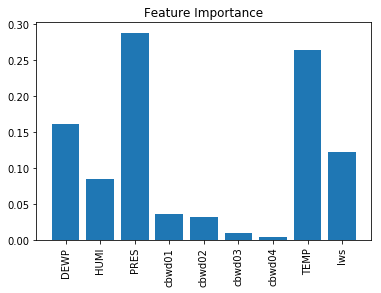

In [19]:
importances = rf_Model.featureImportances
plt.bar(['DEWP','HUMI','PRES','cbwd01','cbwd02','cbwd03','cbwd04','TEMP','Iws'], importances)
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

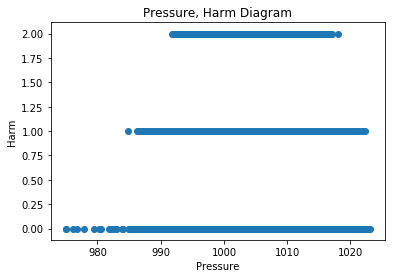

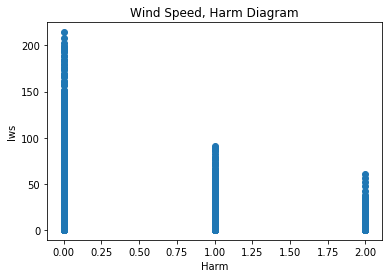

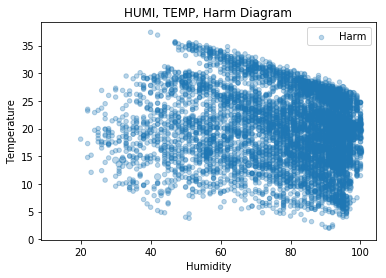

In [20]:
# Data Visualization
df_pandas = df.toPandas()
plt.scatter(df_pandas['PRES'],df_pandas['Harm'])
plt.title("Pressure, Harm Diagram")
plt.xlabel("Pressure")
plt.ylabel("Harm")
plt.show()

plt.scatter(df_pandas['Harm'],df_pandas['Iws'])
plt.title("Wind Speed, Harm Diagram")
plt.xlabel("Harm")
plt.ylabel("Iws")
plt.show()


plt.scatter(df_pandas['HUMI'],df_pandas['TEMP'],df_pandas['Harm']*20, alpha=0.3)
plt.title("HUMI, TEMP, Harm Diagram")
plt.xlabel("Humidity")
plt.ylabel("Temperature")
plt.legend(["Harm"])
plt.show()
